# Dense Neural Network (NN) Exploration

In this notebook, we will lay out our approach for a Neural Network approach to predict a pose based on landmark. Additionally, we are storing out angle calculation and perspectively our angle error calculation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Neural Network

In [2]:
import tensorflow as tf


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Sequential
from tensorflow.keras import models


In [4]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling1D, LeakyReLU
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tensorflow.keras.models import load_model
import joblib

In [5]:
from scipy.stats import uniform

In [6]:
# Load the datasets
train_df = pd.read_csv('train_landmark_xy_raw.csv')
val_df = pd.read_csv('val_landmark_xy_raw.csv')
test_df = pd.read_csv('test_landmark_xy_raw.csv')

In [7]:
X_train = train_df.iloc[:, 1:35]
y_train = train_df['y_main']

In [8]:
X_val = val_df.iloc[:, 1:35]
y_val = val_df['y_main']

In [9]:
X_test = test_df.iloc[:, 1:35]
y_test = test_df['y_main']

In [10]:
X_test.loc[85]

X1     0.280605
Y1     0.479451
X2     0.267260
Y2     0.493526
X3     0.267852
Y3     0.468886
X4     0.273852
Y4     0.507488
X5     0.273602
Y5     0.458069
X6     0.324973
Y6     0.532455
X7     0.328792
Y7     0.432684
X8     0.392967
Y8     0.558411
X9     0.385309
Y9     0.415643
X10    0.361150
Y10    0.510094
X11    0.342062
Y11    0.456945
X12    0.486885
Y12    0.505059
X13    0.481670
Y13    0.448884
X14    0.615836
Y14    0.487272
X15    0.552037
Y15    0.358501
X16    0.723398
Y16    0.469379
X17    0.523754
Y17    0.451854
Name: 85, dtype: float64

In [11]:
# Convert labels to numerical values
label_mapping = {label: idx for idx, label in enumerate(np.unique(y_train))}
y_train_numeric = np.array([label_mapping[label] for label in y_train])
y_val_numeric = np.array([label_mapping[label] for label in y_val])
y_test_numeric = np.array([label_mapping[label] for label in y_test])

In [12]:
label_mapping

{'downdog': 0, 'goddess': 1, 'plank': 2, 'tree': 3, 'warrior2': 4}

In [13]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Saving the scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [14]:
# Convert labels to one-hot encoding
y_train_one_hot = to_categorical(y_train_numeric)
y_val_one_hot = to_categorical(y_val_numeric)
y_test_one_hot = to_categorical(y_test_numeric)

encoder = OneHotEncoder()

# Saving the encoder
joblib.dump(encoder, 'encoder.pkl')

['encoder.pkl']

In [15]:
X_train.shape

(535, 34)

In [16]:
# Build the neural network model
def initialize_model():
    model = models.Sequential()
    model.add(layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(64, activation='relu'))
#     model.add(layers.Dropout(0.5))
#     model.add(layers.Dense(32, activation='relu'))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(len(label_mapping), activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

model = initialize_model()


2023-11-24 16:25:33.319651: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-11-24 16:25:33.319678: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-11-24 16:25:33.319685: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-11-24 16:25:33.319945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-24 16:25:33.320201: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_accuracy', patience=20)

# Start training
history = model.fit(X_train,
                    y_train_one_hot,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val, y_val_one_hot),
                    callbacks=[es])

# # Train the model with validation data
# history = model.fit(X_train,
#                     y_train_one_hot,
#                     epochs=10,
#                     batch_size=32,
#                     validation_data=(X_val, y_val_one_hot))


Epoch 1/100
 8/17 [=============>................] - ETA: 0s - loss: 1.8310 - accuracy: 0.1484

2023-11-24 16:25:33.767824: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2023-11-24 16:25:33.781030: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Unparseable tensorflow.GraphDef proto


17/17 [==============================] - 1s 20ms/step - loss: 1.6172 - accuracy: 0.2766 - val_loss: 1.0321 - val_accuracy: 0.6389
Epoch 2/100
17/17 [==============================] - 0s 9ms/step - loss: 1.1088 - accuracy: 0.5626 - val_loss: 0.7691 - val_accuracy: 0.7569
Epoch 3/100
17/17 [==============================] - 0s 10ms/step - loss: 0.9105 - accuracy: 0.6636 - val_loss: 0.6127 - val_accuracy: 0.8333
Epoch 4/100
17/17 [==============================] - 0s 9ms/step - loss: 0.7823 - accuracy: 0.7159 - val_loss: 0.5185 - val_accuracy: 0.8333
Epoch 5/100
17/17 [==============================] - 0s 9ms/step - loss: 0.6402 - accuracy: 0.7589 - val_loss: 0.4429 - val_accuracy: 0.8403
Epoch 6/100
17/17 [==============================] - 0s 10ms/step - loss: 0.5937 - accuracy: 0.7925 - val_loss: 0.3832 - val_accuracy: 0.8403
Epoch 7/100
17/17 [==============================] - 0s 10ms/step - loss: 0.5534 - accuracy: 0.8019 - val_loss: 0.3520 - val_accuracy: 0.8542
Epoch 8/100
17/17 [==

17/17 [==============================] - 0s 9ms/step - loss: 0.0513 - accuracy: 0.9925 - val_loss: 0.0419 - val_accuracy: 0.9792
Epoch 59/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0587 - accuracy: 0.9907 - val_loss: 0.0444 - val_accuracy: 0.9653
Epoch 60/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0530 - accuracy: 0.9850 - val_loss: 0.0523 - val_accuracy: 0.9583
Epoch 61/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0551 - accuracy: 0.9832 - val_loss: 0.0412 - val_accuracy: 0.9792
Epoch 62/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0590 - accuracy: 0.9757 - val_loss: 0.0488 - val_accuracy: 0.9653
Epoch 63/100
17/17 [==============================] - 0s 10ms/step - loss: 0.0482 - accuracy: 0.9813 - val_loss: 0.0573 - val_accuracy: 0.9583
Epoch 64/100
17/17 [==============================] - 0s 9ms/step - loss: 0.0428 - accuracy: 0.9888 - val_loss: 0.0380 - val_accuracy: 0.9861
Epoch 65/100
17/1

In [18]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4480      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13061 (51.02 KB)
Trainable params: 13061 (51.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


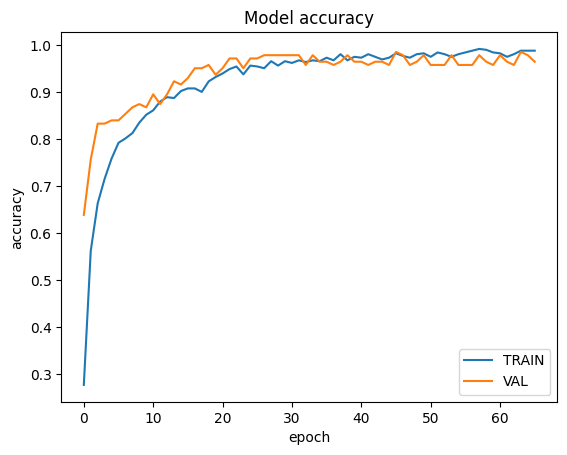

In [19]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()


In [20]:
# # Train the model with validation data
# history = model.fit(X_train,
#                     y_train_one_hot,
#                     epochs=10,
#                     batch_size=32,
#                     validation_data=(X_val, y_val_one_hot))

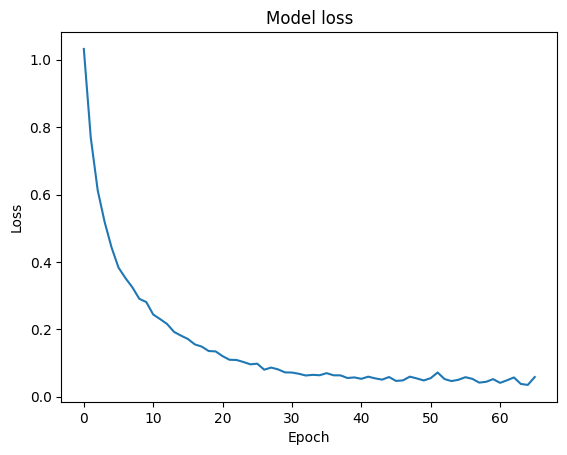

In [21]:
def plot_history(history):
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

plot_history(history)


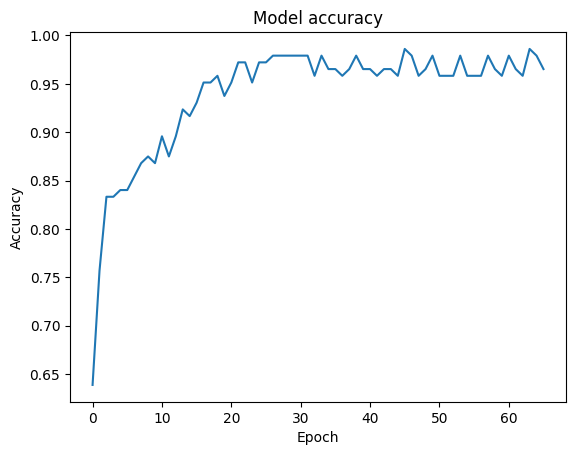

In [22]:
def plot_history_accuracy(history):
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

plot_history_accuracy(history)


In [23]:
# Convert test labels to one-hot encoding
y_test_one_hot = to_categorical(y_test_numeric)

# Evaluate the model on the test set
results = model.evaluate(X_test, y_test_one_hot, verbose=0)


In [24]:
print(f'Test Accuracy: {results[1]*100:.2f}%')
print(f'Test Loss: {results[0]}')


Test Accuracy: 94.81%
Test Loss: 0.15478172898292542


In [25]:
X_test.shape

(154, 34)

In [29]:
X_pred = X_test[85].reshape(1,-1)

In [31]:
%time
prediction = model.predict(X_pred)
prediction

CPU times: user 3 µs, sys: 10 µs, total: 13 µs
Wall time: 32.9 µs
1/1 [==============================] - 0s 12ms/step


array([[2.8202450e-05, 1.1891122e-03, 2.9267329e-05, 9.9758899e-01,
        1.1644369e-03]], dtype=float32)

In [32]:
predict_class = np.argmax(prediction, axis = 1)
predict_class

array([3])

In [33]:
predicted_class_names = [class_name for class_name, idx in label_mapping.items() if idx in predict_class]
predicted_class_names[0]


'tree'

In [ ]:
# def plot_confusion_matrix(cm, classes,
#                           normalize=False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Blues):
#   """Plots the confusion matrix."""
#   if normalize:
#     cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#     print("Normalized confusion matrix")
#   else:
#     print('Confusion matrix, without normalization')

#   plt.imshow(cm, interpolation='nearest', cmap=cmap)
#   plt.title(title)
#   plt.colorbar()
#   tick_marks = np.arange(len(classes))
#   plt.xticks(tick_marks, classes, rotation=55)
#   plt.yticks(tick_marks, classes)
#   fmt = '.2f' if normalize else 'd'
#   thresh = cm.max() / 2.
#   for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#     plt.text(j, i, format(cm[i, j], fmt),
#               horizontalalignment="center",
#               color="white" if cm[i, j] > thresh else "black")

#   plt.ylabel('True label')
#   plt.xlabel('Predicted label')
#   plt.tight_layout()

# # Classify pose in the TEST dataset using the trained model
# y_pred = model.predict(X_test)

# # Convert the prediction result to class name
# y_pred_label = [predict_class[i] for i in np.argmax(y_pred, axis=1)]
# y_true_label = [predict_class[i] for i in np.argmax(y_test, axis=1)]

# # Plot the confusion matrix
# cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
# plot_confusion_matrix(cm,
#                       class_names,
#                       title ='Confusion Matrix of Pose Classification Model')

# # Print the classification report
# print('\nClassification Report:\n', classification_report(y_true_label,
#                                                           y_pred_label))


In [ ]:
model.save('24112023_model.h5')  # Save the entire model

In [ ]:
model.save('24112023_model.keras')  # Save the entire model